In [ ]:
!nvidia-smi

Sun Nov 14 06:45:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install optuna
from scipy.io import loadmat
import torch as tr
import torch.nn as nn
from time import time
from matplotlib import pyplot as plt
import os
import cv2
from math import ceil
import numpy as np
from tqdm import tqdm
import torchvision
from PIL import Image
import tensorflow as tf
import optuna
from sklearn.metrics import mean_squared_error

     |████████████████████████████████| 308 kB 6.8 MB/s 
     |████████████████████████████████| 209 kB 60.7 MB/s 
     |████████████████████████████████| 80 kB 12.8 MB/s 
     |████████████████████████████████| 75 kB 6.3 MB/s 
     |████████████████████████████████| 112 kB 81.0 MB/s 
     |████████████████████████████████| 148 kB 75.6 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=ebb33e50d15be03ebdd827c282dea0649f444e263ec93ce667eb390ee21eb5d6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# device info
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# data paths extraction
# train_rw_path = '/content/drive/MyDrive/HSFMRGB/Prep_02/NTIRE_Train_Clean'
# train_spec_path = '/content/drive/MyDrive/HSFMRGB/Prep_02/NTIRE_Train_Spectral'

train_rw_path = '/content/drive/MyDrive/HSFMRGB/Preprocessed_Datasets/NTIRE_Train_Clean_256'
train_spec_path = '/content/drive/MyDrive/HSFMRGB/Preprocessed_Datasets/NTIRE_Train_Spectral_256'

sp_filename = 'ARAD_HS_'
rw_filename = '_clean'

tsp_paths = os.listdir(train_spec_path)
trw_paths = os.listdir(train_rw_path)[:len(tsp_paths)]
print('train rw paths :',len(trw_paths))
print('train spec paths :',len(tsp_paths))

train rw paths : 450
train spec paths : 450


In [ ]:
img_index = 1
img1 = cv2.imread(os.path.join(train_rw_path,'{}{:04d}{}.png'.format(sp_filename,img_index,rw_filename)))
img_data = loadmat(os.path.join(train_spec_path,'{}{:04d}.mat'.format(sp_filename,img_index)))
img_bands,img2 = img_data['bands'],img_data['cube']
print('RGB image shape :',img1.shape,' || type :',type(img1))
print('Spectral image shape :',img2.shape,' || type :',type(img2))

RGB image shape : (256, 256, 3)  || type : <class 'numpy.ndarray'>
Spectral image shape : (256, 256, 31)  || type : <class 'numpy.ndarray'>


In [ ]:
bands = [400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700]

In [ ]:
def getImage(indexs):
  jpgs , specs = [],[]
  for index in indexs:
    jpg = cv2.imread(os.path.join(train_rw_path,'{}{:04d}{}.png'.format(sp_filename,index,rw_filename)))
    data = loadmat(os.path.join(train_spec_path,'{}{:04d}.mat'.format(sp_filename,index)))
    spec = data['cube'][:,:,12:15]
    jpgs.append(jpg)
    specs.append(spec)
  
  jpgs = tr.from_numpy(np.array(jpgs))
  specs = tr.Tensor(specs)
  jpgs = tr.reshape(jpgs,(len(indexs),3,256,256))
  specs = tr.reshape(specs,(len(indexs),3,256,256))
  
  return jpgs,specs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



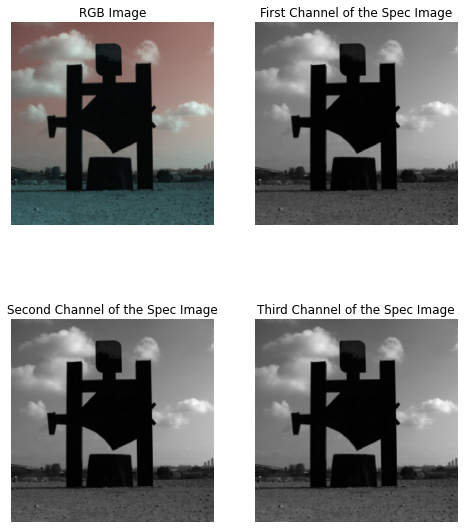

In [ ]:
jpgs,specs = getImage([450])

jpg = tr.reshape(jpgs,(256,256,3))
spec = tr.reshape(specs,(256,256,3))

# plot the pics 
plt.figure(figsize=(8,10))
plt.subplot(2,2,1)
plt.title('RGB Image')
plt.axis('off')
plt.imshow(jpg,cmap='gray')

plt.subplot(2,2,2)
plt.title('First Channel of the Spec Image')
plt.axis('off')
img = tr.reshape(spec[:,:,:1],(256,256))
plt.imshow(img,cmap='gray')

plt.subplot(2,2,3)
plt.title('Second Channel of the Spec Image')
plt.axis('off')
img = tr.reshape(spec[:,:,1:2],(256,256))
plt.imshow(img,cmap='gray')

plt.subplot(2,2,4)
plt.title('Third Channel of the Spec Image')
plt.axis('off')
img = tr.reshape(spec[:,:,2:],(256,256))
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
# Generator Model
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.leaky1 = nn.LeakyReLU(0.2)
    self.leaky2 = nn.LeakyReLU(0.2)
    self.leaky3 = nn.LeakyReLU(0.2)
    self.leaky4 = nn.LeakyReLU(0.2)
   

    self.relu1 = nn.ReLU(inplace=True)
    self.relu2 = nn.ReLU(inplace=True)
    self.relu3 = nn.ReLU(inplace=True)
    self.relu4 = nn.ReLU(inplace=True)
    self.relu5 = nn.ReLU(inplace=True)
  
    self.bn1_64 = nn.BatchNorm2d(64)
    self.bn2_64 = nn.BatchNorm2d(64)

    self.bn1_128 = nn.BatchNorm2d(128)
    self.bn2_128 = nn.BatchNorm2d(128)

    self.bn1_256 = nn.BatchNorm2d(256)
    self.bn2_256 = nn.BatchNorm2d(256)

    self.bn1_512 = nn.BatchNorm2d(512)
    self.bn2_512 = nn.BatchNorm2d(512)
    self.bn3_512 = nn.BatchNorm2d(512)
    self.bn4_512 = nn.BatchNorm2d(512)

    self.drop1 = nn.Dropout(0.5)
    self.drop2 = nn.Dropout(0.5)
    

    self.tanh = nn.Tanh()

    self.conv1 = nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1)
    self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
    self.conv3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1)
    self.conv4 = nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1)
   
    
    self.bottleneck = nn.Conv2d(512,512,kernel_size=4,stride=2,padding=1)

    self.tconv1 = nn.ConvTranspose2d(512,512,kernel_size=4,stride=2,padding=1)
    self.tconv2 = nn.ConvTranspose2d(1024,256,kernel_size=4,stride=2,padding=1) # 1,5
    self.tconv3 = nn.ConvTranspose2d(512,128,kernel_size=4,stride=2,padding=1) # 2,4 
    self.tconv4 = nn.ConvTranspose2d(256,64,kernel_size=4,stride=2,padding=1) # 3,3
  

    self.final = nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=1) # 5,1
    
    
  def forward(self,x):
    d1 = self.leaky1(self.conv1(x))
    d2 = self.leaky2(self.bn1_128(self.conv2(d1)))
    d3 = self.leaky3(self.bn1_256(self.conv3(d2)))
    d4 = self.leaky4(self.bn1_512(self.conv4(d3)))
   
    bottleneck = self.drop1(self.relu1(self.bottleneck(d4)))
    
    up1 = self.drop2(self.relu2(self.bn2_512(self.tconv1(bottleneck))))
    up2 = self.relu3(self.bn2_256(self.tconv2(tr.cat([up1,d4],1))))
    up3 = self.relu4(self.bn2_128(self.tconv3(tr.cat([up2,d3],1))))
    up4 = self.relu5(self.bn1_64(self.tconv4(tr.cat([up3,d2],1))))
 
    final = self.tanh(self.final(tr.cat([up4,d1],1)))

    return final


In [ ]:
netG = Generator().to(device)
if __name__ == '__main__':
  with tr.no_grad():
      input = tr.randn((1,3,256,256),device=device)
      start = time()
      output = netG(input)
      end = time()
      print('time :',end-start,'sec')
      print(output.shape)
print(netG)

time : 0.354888916015625 sec
torch.Size([1, 3, 256, 256])
Generator(
  (leaky1): LeakyReLU(negative_slope=0.2)
  (leaky2): LeakyReLU(negative_slope=0.2)
  (leaky3): LeakyReLU(negative_slope=0.2)
  (leaky4): LeakyReLU(negative_slope=0.2)
  (relu1): ReLU(inplace=True)
  (relu2): ReLU(inplace=True)
  (relu3): ReLU(inplace=True)
  (relu4): ReLU(inplace=True)
  (relu5): ReLU(inplace=True)
  (bn1_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_512): BatchNorm2d(512, eps=1e-05, momentum=0.1

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.leaky1 = nn.LeakyReLU(0.2)
    self.leaky2 = nn.LeakyReLU(0.2)
    self.leaky3 = nn.LeakyReLU(0.2)
    self.leaky4 = nn.LeakyReLU(0.2)

    self.bn128 = nn.BatchNorm2d(128)
    self.bn256 = nn.BatchNorm2d(256)
    self.bn512 = nn.BatchNorm2d(512)


    self.conv1 = nn.Conv2d(6,64,kernel_size=4,stride=1,padding=1)
    self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
    self.conv3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1)
    self.conv4 = nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1)
    self.final = nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1)

  def forward(self,x):
    d1 = self.leaky1(self.conv1(x))
    d2 = self.leaky2(self.bn128(self.conv2(d1)))
    d3 = self.leaky3(self.bn256(self.conv3(d2)))
    d4 = self.leaky4(self.bn512(self.conv4(d3)))
    final = nn.Sigmoid()(self.final(d4))
    return final

In [ ]:
netD = Discriminator().to(device)
if __name__ == '__main__':
  with tr.no_grad():
    input = tr.randn((1,6,256,256),device=device)
    start = time()
    output = netD(input)
    end = time()
    print('time :',end-start,'sec')
    print(output.shape)
print(netD)

time : 0.01588726043701172 sec
torch.Size([1, 1, 30, 30])
Discriminator(
  (leaky1): LeakyReLU(negative_slope=0.2)
  (leaky2): LeakyReLU(negative_slope=0.2)
  (leaky3): LeakyReLU(negative_slope=0.2)
  (leaky4): LeakyReLU(negative_slope=0.2)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)


In [ ]:
batch_size = 1
lrG = 2e-4
lrD = 2e-4
num_epochs = 20
criterion = nn.BCELoss()
L1 = nn.L1Loss()

In [ ]:
# train the model
G_errors , D_errors = [],[]

def model_train(trail):
  global G_errors,D_errors 
  lmd = trail.suggest_uniform('lmd',50,500)
  # lrG = trail.suggest_uniform('lrG',2e-4,1e-1)
  # lrD = trail.suggest_uniform('lrD',2e-4,1e-1)
  # b1 = trail.suggest_uniform('b1',0.1,0.99)
  # b2 = trail.suggest_uniform('b2',0.1,0.99)

  optimizerG = tr.optim.Adam(netG.parameters(),lr=lrG,betas=(0.5,0.999))
  optimizerD = tr.optim.Adam(netD.parameters(),lr=lrD,betas=(0.5,0.999))
  g_scaler = tr.cuda.amp.GradScaler()
  d_scaler = tr.cuda.amp.GradScaler()


  G_errors , D_errors = [],[]
  for epoch in range(num_epochs):
    tG , tD = 0 , 0
    G_targets,G_preds = [],[]
    D_targets,D_preds = [],[]
    for i in tqdm(range(1,451,batch_size),desc=f'Training.... {epoch}'):
      netD.zero_grad()
      indexs = [j for j in range(i,i+batch_size if i+batch_size <= 451 else 451)]
      jpgs_real,specs_real = getImage(indexs)
      jpgs_real = jpgs_real.to(device)
      specs_real = specs_real.to(device)
      specs_fake = netG(jpgs_real.float())

      concat_real = tr.cat((jpgs_real,specs_real),1)
      real_patch = netD(concat_real)


      concat_fake = tr.cat((jpgs_real,specs_fake),1)
      fake_patch = netD(concat_fake.detach())

      real_label = tr.ones_like(real_patch,dtype=tr.float,device=device)
      real_loss = criterion(real_patch,real_label)

      G_targets.append([val for val in real_label.reshape((-1))])
      G_preds.append([val for val in real_patch.reshape((-1))])
      

      fake_label = tr.zeros_like(fake_patch,dtype=tr.float,device=device)
      fake_loss = criterion(fake_patch,fake_label)

      D_targets.append([val for val in fake_label.reshape((-1))])
      D_preds.append([val for val in fake_patch.reshape((-1))])
      
      D_loss = (real_loss + fake_loss)/2
      tD += D_loss.item()
      d_scaler.scale(D_loss).backward()
      d_scaler.step(optimizerD)
      d_scaler.update()
      
      netG.zero_grad()
      real_label.fill_(1)
      fake_patch = netD(concat_fake)
      netG_Adv_Loss = criterion(fake_patch,real_label)
      L1_loss = L1(specs_fake,specs_real.to(device))
      G_loss = netG_Adv_Loss + L1_loss*lmd
      tG += G_loss.item()

      g_scaler.scale(G_loss).backward()
      g_scaler.step(optimizerG)
      g_scaler.update()
      
    G_errors.append(tG)
    D_errors.append(tD)
    G_mse,D_mse = mean_squared_error(G_targets,G_preds),mean_squared_error(D_targets,D_preds)
    print(f'Gloss : {G_errors[-1]}, Dloss : {D_errors[-1]}')
    print(f'GMSE : {G_mse}, DMSE : {D_mse}')
    
  return G_mse+D_mse

study = optuna.create_study()
study.optimize(model_train,n_trials=10)
study.best_params

[I 2021-11-14 06:46:26,487] A new study created in memory with name: no-name-a725839f-fc41-4e59-8080-4b430fa1a208
Training.... 0: 100%|██████████| 450/450 [08:15<00:00,  1.10s/it]


Gloss : 56056.28742599487, Dloss : 314.79291677474976
GMSE : 0.2528879757120568, DMSE : 0.2526036603659616


Training.... 1: 100%|██████████| 450/450 [01:51<00:00,  4.03it/s]


Gloss : 49703.15942001343, Dloss : 312.36452692747116
GMSE : 0.25056901734488535, DMSE : 0.25021285490101103


Training.... 2: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 45434.4135093689, Dloss : 191.8087112084031
GMSE : 0.1326382013510367, DMSE : 0.14073982511646588


Training.... 3: 100%|██████████| 450/450 [01:49<00:00,  4.12it/s]


Gloss : 43176.00341796875, Dloss : 55.71629985840991
GMSE : 0.025252356173443173, DMSE : 0.03146753343089306


Training.... 4: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 41008.40951538086, Dloss : 20.158400246407837
GMSE : 0.008384353153132788, DMSE : 0.009451766747551178


Training.... 5: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 39778.38399505615, Dloss : 15.328897908446379
GMSE : 0.0070122225449975855, DMSE : 0.008174505431726068


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 39840.3835105896, Dloss : 39.95999434811529
GMSE : 0.019988687949612192, DMSE : 0.023401767291236737


Training.... 7: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 37756.1674156189, Dloss : 18.73150627000723
GMSE : 0.01002664197593639, DMSE : 0.010423600271455679


Training.... 8: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 36513.547592163086, Dloss : 24.64211828436237
GMSE : 0.01207338014467645, DMSE : 0.012159624221609799


Training.... 9: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 36884.48120498657, Dloss : 10.447614905599039
GMSE : 0.005796134634344079, DMSE : 0.0059386433091645945


Training.... 10: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 34298.240842819214, Dloss : 4.30316095019225
GMSE : 0.0008479947170963192, DMSE : 0.002593467947561465


Training.... 11: 100%|██████████| 450/450 [01:49<00:00,  4.13it/s]


Gloss : 34019.33661842346, Dloss : 3.057458645751467
GMSE : 0.0010533456580468802, DMSE : 0.0015094083490125468


Training.... 12: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 31649.931671142578, Dloss : 26.307230774633354
GMSE : 0.015779383944411782, DMSE : 0.015044765292446851


Training.... 13: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 32122.979106903076, Dloss : 25.056160463398555
GMSE : 0.012952997970352776, DMSE : 0.013093623845194365


Training.... 14: 100%|██████████| 450/450 [01:48<00:00,  4.17it/s]


Gloss : 31876.647356033325, Dloss : 7.376789046247723
GMSE : 0.0026330471867290267, DMSE : 0.0043548633770504755


Training.... 15: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 31203.115533828735, Dloss : 3.771798766036227
GMSE : 0.0016321944305235563, DMSE : 0.0022028364433112403


Training.... 16: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 31792.44422531128, Dloss : 0.6710128791746683
GMSE : 2.547318317396572e-05, DMSE : 9.97148980040795e-05


Training.... 17: 100%|██████████| 450/450 [01:48<00:00,  4.13it/s]


Gloss : 30771.167064666748, Dloss : 46.914810070775275
GMSE : 0.021242615771629003, DMSE : 0.021126863217419075


Training.... 18: 100%|██████████| 450/450 [01:47<00:00,  4.21it/s]


Gloss : 28044.975351333618, Dloss : 11.718997019095696
GMSE : 0.005078682754862237, DMSE : 0.007786693733136299


Training.... 19: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]
[I 2021-11-14 07:34:32,547] Trial 0 finished with value: 0.0005551372632008407 and parameters: {'lmd': 157.79845558750935}. Best is trial 0 with value: 0.0005551372632008407.


Gloss : 28069.44008255005, Dloss : 1.2621310406611883
GMSE : 0.00013362630310424407, DMSE : 0.0004215109600965967


Training.... 0: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 28180.904790878296, Dloss : 9.75834598482652
GMSE : 0.00411105288421226, DMSE : 0.00503873301004066


Training.... 1: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 27965.913524627686, Dloss : 18.332028401375283
GMSE : 0.009998347981416649, DMSE : 0.011423519442759048


Training.... 2: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 28398.073972702026, Dloss : 6.5299824182802695
GMSE : 0.003968491742296213, DMSE : 0.0034237583846893197


Training.... 3: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 28267.914138793945, Dloss : 0.7884380018404045
GMSE : 5.092925178948715e-05, DMSE : 0.0002227608647564069


Training.... 4: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 27513.746377944946, Dloss : 0.18197091038018698
GMSE : 1.6838493079696445e-06, DMSE : 1.5876617873150395e-06


Training.... 5: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 27873.964056015015, Dloss : 21.54566111672466
GMSE : 0.00976744419454457, DMSE : 0.010276434709476435


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 26948.45175552368, Dloss : 2.0992939920906792
GMSE : 0.0005535279841981221, DMSE : 0.0012460252636877316


Training.... 7: 100%|██████████| 450/450 [01:48<00:00,  4.17it/s]


Gloss : 26323.068603515625, Dloss : 12.943744422922464
GMSE : 0.0053994373187628425, DMSE : 0.00446406561636936


Training.... 8: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 26719.186237335205, Dloss : 0.6646596754253551
GMSE : 5.45394909756218e-05, DMSE : 9.518855565484266e-05


Training.... 9: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 26426.627923965454, Dloss : 9.03755489055402
GMSE : 0.0049384019575380725, DMSE : 0.0009774360462290934


Training.... 10: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 23689.60986804962, Dloss : 120.51058588596061
GMSE : 0.06935307384168173, DMSE : 0.07829271310239234


Training.... 11: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 24723.291717529297, Dloss : 2.075753288634587
GMSE : 0.00019971051363801986, DMSE : 0.0005312857461301275


Training.... 12: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 25456.356820106506, Dloss : 0.9052781556456466
GMSE : 5.3238382739976574e-05, DMSE : 9.498343757002312e-05


Training.... 13: 100%|██████████| 450/450 [01:47<00:00,  4.21it/s]


Gloss : 24372.147004127502, Dloss : 0.8588357608459773
GMSE : 7.42374869866897e-05, DMSE : 0.00010892482762244676


Training.... 14: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 23617.582487106323, Dloss : 0.4897353031701641
GMSE : 2.305539343963387e-05, DMSE : 4.3745627743318564e-05


Training.... 15: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 23686.874263763428, Dloss : 31.89563127845031
GMSE : 0.01664610826499631, DMSE : 0.017027995179016604


Training.... 16: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 22435.87370300293, Dloss : 24.734398401036742
GMSE : 0.010922095755202955, DMSE : 0.014018043799338605


Training.... 17: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 22271.499062538147, Dloss : 1.578159138050978
GMSE : 0.00022675478330392936, DMSE : 0.0003753059214517966


Training.... 18: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 22617.80430984497, Dloss : 12.888327288499568
GMSE : 0.007201123876843396, DMSE : 0.005852565794424485


Training.... 19: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 22326.163385391235, Dloss : 1.1705168026455794
GMSE : 0.00014477850371538096, DMSE : 0.00018822348812477766


[I 2021-11-14 08:16:03,763] Trial 1 finished with value: 0.0003330019918401586 and parameters: {'lmd': 165.046062725104}. Best is trial 1 with value: 0.0003330019918401586.
Training.... 0: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 42655.50447463989, Dloss : 18.756996417516348
GMSE : 0.011309265440929974, DMSE : 0.010577059493920639


Training.... 1: 100%|██████████| 450/450 [01:49<00:00,  4.12it/s]


Gloss : 42101.35732269287, Dloss : 1.7371858866899856
GMSE : 0.0005999125499214653, DMSE : 0.0006441373270994667


Training.... 2: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 41693.746713638306, Dloss : 17.08819591833526
GMSE : 0.007809782304393824, DMSE : 0.009425370278130937


Training.... 3: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 42021.758977890015, Dloss : 11.851066688399442
GMSE : 0.007884566219912596, DMSE : 0.006539554146010157


Training.... 4: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 40080.92156600952, Dloss : 1.0316596303819097
GMSE : 0.00019546075314948717, DMSE : 0.0003101098024604058


Training.... 5: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 40651.38228607178, Dloss : 0.6667831681043026
GMSE : 5.308492765508832e-05, DMSE : 0.00023368271256357062


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 40582.40872192383, Dloss : 0.2624620178303303
GMSE : 1.0285358564559726e-05, DMSE : 2.2115673622162788e-05


Training.... 7: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 40021.7533531189, Dloss : 0.43904733672934526
GMSE : 3.841254857603972e-05, DMSE : 0.00012598988641614187


Training.... 8: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 39401.34804725647, Dloss : 0.27073434438261756
GMSE : 1.3670321111326576e-05, DMSE : 4.95285181883574e-05


Training.... 9: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 38782.226501464844, Dloss : 0.10128142102985294
GMSE : 2.127542262089954e-06, DMSE : 4.1022785546547815e-06


Training.... 10: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 39505.881843566895, Dloss : 0.10104747736750141
GMSE : 3.1212453694859365e-06, DMSE : 9.100617857304174e-06


Training.... 11: 100%|██████████| 450/450 [01:49<00:00,  4.12it/s]


Gloss : 39036.15503120422, Dloss : 0.06922234992862286
GMSE : 6.418617416460007e-07, DMSE : 1.674250665318178e-06


Training.... 12: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 38166.05166053772, Dloss : 0.08603370108176023
GMSE : 1.2789411823529354e-06, DMSE : 3.5275709054605027e-06


Training.... 13: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 38644.99488449097, Dloss : 0.08121153226420574
GMSE : 1.1483673475128923e-06, DMSE : 5.088237520315609e-06


Training.... 14: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 36399.33747673035, Dloss : 113.08785115380351
GMSE : 0.056224050936437016, DMSE : 0.06039837914675914


Training.... 15: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 34780.4336605072, Dloss : 21.27670741864131
GMSE : 0.012687791014278705, DMSE : 0.011567607704994484


Training.... 16: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 34420.628995895386, Dloss : 3.7453358447965
GMSE : 0.0010288710049405237, DMSE : 0.0019162805542471744


Training.... 17: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 34542.943519592285, Dloss : 12.698527447566448
GMSE : 0.008187938980023186, DMSE : 0.0068973587043178065


Training.... 18: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 34933.96920013428, Dloss : 1.5207382594817318
GMSE : 0.0002902402567763724, DMSE : 0.0005388506913562055


Training.... 19: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]
[I 2021-11-14 08:57:45,043] Trial 2 finished with value: 0.027974387096952658 and parameters: {'lmd': 346.14558351142256}. Best is trial 1 with value: 0.0003330019918401586.


Gloss : 33825.88544845581, Dloss : 24.409995565583813
GMSE : 0.014538692752499935, DMSE : 0.013435694344452721


Training.... 0: 100%|██████████| 450/450 [01:48<00:00,  4.13it/s]


Gloss : 38269.40627479553, Dloss : 6.4021281524328515
GMSE : 0.002979925837758794, DMSE : 0.004247299631634173


Training.... 1: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 38400.18098831177, Dloss : 0.48445945218918496
GMSE : 4.974687213699278e-05, DMSE : 8.346472850057096e-05


Training.... 2: 100%|██████████| 450/450 [01:49<00:00,  4.12it/s]


Gloss : 37799.34719657898, Dloss : 0.2194828593856073
GMSE : 5.730564765544689e-06, DMSE : 1.8314919994071014e-05


Training.... 3: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 35225.996574401855, Dloss : 51.44414710576166
GMSE : 0.026130764361193586, DMSE : 0.02657323205934856


Training.... 4: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 35497.43130493164, Dloss : 3.1142422764969524
GMSE : 0.001217848452646518, DMSE : 0.001529371896260069


Training.... 5: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 35168.712799072266, Dloss : 1.2696828594052931
GMSE : 0.00022210474693240087, DMSE : 0.00044621771411802323


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 34555.62360572815, Dloss : 0.5906300179194659
GMSE : 6.45345593940031e-05, DMSE : 0.00014438919625251834


Training.... 7: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 34100.97027206421, Dloss : 14.833322311551456
GMSE : 0.008426007920485376, DMSE : 0.00705233485200742


Training.... 8: 100%|██████████| 450/450 [01:46<00:00,  4.22it/s]


Gloss : 34625.98246002197, Dloss : 1.1126273482732358
GMSE : 0.0002512891947589255, DMSE : 0.0004760002477014311


Training.... 9: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 33511.04028129578, Dloss : 18.074634125434386
GMSE : 0.009663187511420857, DMSE : 0.007447795546932409


Training.... 10: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 32738.41696548462, Dloss : 16.603983355904347
GMSE : 0.009284477107697782, DMSE : 0.01095411893621472


Training.... 11: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 32325.41781425476, Dloss : 0.7521839639521204
GMSE : 0.00015993536444229244, DMSE : 0.00011194242007064201


Training.... 12: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 32561.599157333374, Dloss : 0.5259641691118304
GMSE : 5.78918947273161e-05, DMSE : 5.6449606914362064e-05


Training.... 13: 100%|██████████| 450/450 [01:48<00:00,  4.13it/s]


Gloss : 31958.502126693726, Dloss : 0.3962116871298349
GMSE : 1.913769807587071e-05, DMSE : 0.00013721988783400375


Training.... 14: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 31706.438608169556, Dloss : 0.32608835312203155
GMSE : 3.2486154331495195e-05, DMSE : 6.258287135286014e-05


Training.... 15: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 30600.051414489746, Dloss : 36.435998887849564
GMSE : 0.016937294448927682, DMSE : 0.020594905687203343


Training.... 16: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 31128.861053466797, Dloss : 2.3595428354819887
GMSE : 0.0008561491949873501, DMSE : 0.0009844690972900284


Training.... 17: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 30591.101009368896, Dloss : 0.8986685061718163
GMSE : 8.30283832993091e-05, DMSE : 0.00022729142290339017


Training.... 18: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 29713.19913673401, Dloss : 14.903106314390243
GMSE : 0.00877865879936449, DMSE : 0.009104564385647072


Training.... 19: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]
[I 2021-11-14 09:39:17,881] Trial 3 finished with value: 0.001399576615840446 and parameters: {'lmd': 388.6219647882648}. Best is trial 1 with value: 0.0003330019918401586.


Gloss : 30263.117441177368, Dloss : 1.6832648567178694
GMSE : 0.00046652561454402827, DMSE : 0.0009330510012964178


Training.... 0: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 28615.511421203613, Dloss : 2.72289493757944
GMSE : 0.0015731589612614223, DMSE : 0.0014973423643859912


Training.... 1: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 27649.556184768677, Dloss : 16.924529577012436
GMSE : 0.008365642645833619, DMSE : 0.01114607755404013


Training.... 2: 100%|██████████| 450/450 [01:46<00:00,  4.22it/s]


Gloss : 27707.160676956177, Dloss : 0.4359611236213823
GMSE : 2.3884662762322085e-05, DMSE : 7.093608021004455e-05


Training.... 3: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 27393.963075637817, Dloss : 0.293907199640671
GMSE : 2.2764167898242873e-05, DMSE : 4.1939546818716595e-05


Training.... 4: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 27004.15027809143, Dloss : 0.35409767953933624
GMSE : 3.9066692272583464e-05, DMSE : 0.00016704448518244856


Training.... 5: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 27114.8438911438, Dloss : 0.1519176687252184
GMSE : 5.347529097385357e-06, DMSE : 2.760737882170908e-05


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 26494.407258987427, Dloss : 0.18290456507475028
GMSE : 6.3855647090576805e-06, DMSE : 4.4307324835082506e-05


Training.... 7: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 26056.365774154663, Dloss : 0.15853093097302917
GMSE : 7.611995511460879e-06, DMSE : 1.2783661398057873e-05


Training.... 8: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 25011.87176132202, Dloss : 106.02849444484536
GMSE : 0.04554565828955666, DMSE : 0.05395296533717073


Training.... 9: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 23960.94532775879, Dloss : 13.00315489168861
GMSE : 0.007138310739038466, DMSE : 0.00824040592516898


Training.... 10: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 23926.907802581787, Dloss : 7.580830961320316
GMSE : 0.0038035564008194866, DMSE : 0.005105251845068573


Training.... 11: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 23943.90725326538, Dloss : 0.7859493515643408
GMSE : 5.5415812909608826e-05, DMSE : 0.00018299854165676138


Training.... 12: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 24094.86836051941, Dloss : 1.0502366567816352
GMSE : 0.00017015936289517468, DMSE : 0.0004333023668151053


Training.... 13: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 23809.346601486206, Dloss : 0.4647925532244699
GMSE : 4.8228818624813404e-05, DMSE : 5.3659874337469574e-05


Training.... 14: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 23284.734197616577, Dloss : 0.33911166192592646
GMSE : 2.6983934878923074e-05, DMSE : 2.3433315054730735e-05


Training.... 15: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 23600.171146392822, Dloss : 0.2056630749211763
GMSE : 4.973222297533381e-06, DMSE : 2.7600093950415742e-05


Training.... 16: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 22940.96953201294, Dloss : 0.2127555707720603
GMSE : 8.171723702836667e-06, DMSE : 2.5565285198289298e-05


Training.... 17: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 22250.811153411865, Dloss : 25.911886664176563
GMSE : 0.01404332055981141, DMSE : 0.01305906934398075


Training.... 18: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 22397.525497436523, Dloss : 3.247934887869633
GMSE : 0.0011943845004177102, DMSE : 0.0025153711069611246


Training.... 19: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]
[I 2021-11-14 10:20:43,770] Trial 4 finished with value: 0.0007297807087664644 and parameters: {'lmd': 364.3027036259928}. Best is trial 1 with value: 0.0003330019918401586.


Gloss : 21998.66396713257, Dloss : 0.7236706885050808
GMSE : 0.00023770274105745968, DMSE : 0.0004920779677090048


Training.... 0: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 9107.440444946289, Dloss : 0.4255461830898639
GMSE : 0.00010719404377410454, DMSE : 0.00029736597246131163


Training.... 1: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 9463.763999938965, Dloss : 11.973989893327143
GMSE : 0.006626884260119815, DMSE : 0.0054571215331969255


Training.... 2: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 9084.642135620117, Dloss : 0.1732733574735903
GMSE : 1.3837134385935854e-05, DMSE : 6.387500454002636e-05


Training.... 3: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 9138.152605056763, Dloss : 0.06352484827766602
GMSE : 8.841356582043183e-07, DMSE : 5.946799440065779e-06


Training.... 4: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 8676.40786933899, Dloss : 6.710134621941052
GMSE : 0.003362564824654842, DMSE : 0.003540410818474493


Training.... 5: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 8908.70304107666, Dloss : 7.134398281513313
GMSE : 0.0032428440102657114, DMSE : 0.005038540360750038


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 8288.564299583435, Dloss : 0.5025822764728218
GMSE : 4.6683631135093494e-05, DMSE : 0.000377095152186617


Training.... 7: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 8234.333627700806, Dloss : 0.08083303779221751
GMSE : 2.072198978492669e-06, DMSE : 2.5199332091581896e-06


Training.... 8: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 8507.993335723877, Dloss : 15.57643959298548
GMSE : 0.00720674620551731, DMSE : 0.007670623197774448


Training.... 9: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 8996.207350730896, Dloss : 0.5547894000010274
GMSE : 4.1461871880577726e-05, DMSE : 0.00019634473438892322


Training.... 10: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 9788.74695777893, Dloss : 1.5780696297097165
GMSE : 0.000680737582790438, DMSE : 0.0006304016325881338


Training.... 11: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 9418.845331192017, Dloss : 0.8149124211913659
GMSE : 0.00012934736645872223, DMSE : 0.0003023727411318564


Training.... 12: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 9023.007995605469, Dloss : 20.318524091988365
GMSE : 0.009826179214214671, DMSE : 0.010207767329106601


Training.... 13: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 9051.700497627258, Dloss : 9.233931774870143
GMSE : 0.004924085565587344, DMSE : 0.00567450975550516


Training.... 14: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 8612.94517993927, Dloss : 1.2439178339718637
GMSE : 0.00023295836562767385, DMSE : 0.0009294409416519837


Training.... 15: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 8141.769309997559, Dloss : 0.39146529090066906
GMSE : 3.608996883096104e-05, DMSE : 0.00023358045624517315


Training.... 16: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 8201.573428153992, Dloss : 11.64203679869479
GMSE : 0.005265403453769296, DMSE : 0.004761515175929263


Training.... 17: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 7526.30948638916, Dloss : 2.715719049321706
GMSE : 0.001461017642044111, DMSE : 0.0016899898146650564


Training.... 18: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 7737.588672637939, Dloss : 8.652901455160645
GMSE : 0.005241286947233125, DMSE : 0.005117321113452434


Training.... 19: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]
[I 2021-11-14 11:02:16,685] Trial 5 finished with value: 0.008793197283074213 and parameters: {'lmd': 76.44316261226862}. Best is trial 1 with value: 0.0003330019918401586.


Gloss : 7700.861386299133, Dloss : 7.281243083266418
GMSE : 0.004547734934663127, DMSE : 0.004245462348411087


Training.... 0: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 8863.664686203003, Dloss : 9.52648340345877
GMSE : 0.0038642427129123857, DMSE : 0.006787854005325099


Training.... 1: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 9088.985898971558, Dloss : 0.5606753632528125
GMSE : 0.0001968603220716089, DMSE : 0.00025036187406398357


Training.... 2: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 9041.696514129639, Dloss : 0.283911781723873
GMSE : 1.9135048514772958e-05, DMSE : 0.00011372103449985689


Training.... 3: 100%|██████████| 450/450 [01:49<00:00,  4.12it/s]


Gloss : 8640.760388374329, Dloss : 16.765988029310392
GMSE : 0.006751926557439006, DMSE : 0.008622114506091972


Training.... 4: 100%|██████████| 450/450 [01:49<00:00,  4.13it/s]


Gloss : 9128.066276550293, Dloss : 0.23970289876524475
GMSE : 1.148932882261758e-05, DMSE : 6.207563925861099e-05


Training.... 5: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 8569.658635139465, Dloss : 0.5130172977496841
GMSE : 0.00021319438800520462, DMSE : 0.0002762080963911572


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 8656.884337425232, Dloss : 0.9323845846902259
GMSE : 0.0004026975394647455, DMSE : 0.0005866897768851609


Training.... 7: 100%|██████████| 450/450 [01:49<00:00,  4.13it/s]


Gloss : 8848.782738685608, Dloss : 0.9269020462243134
GMSE : 0.0008055466073086124, DMSE : 0.00021524116748464567


Training.... 8: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 8362.527577400208, Dloss : 24.815451004513307
GMSE : 0.0093375890708874, DMSE : 0.01245493335885182


Training.... 9: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 9370.825873374939, Dloss : 3.0164128474079916
GMSE : 0.0013729948591115347, DMSE : 0.0017875927684421634


Training.... 10: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 8491.033109664917, Dloss : 0.28335017687732034
GMSE : 3.81316860603411e-05, DMSE : 7.630186254786554e-05


Training.... 11: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 7791.281396865845, Dloss : 0.12831642615674355
GMSE : 4.691140416749764e-06, DMSE : 1.2826914598850531e-05


Training.... 12: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 8050.651031494141, Dloss : 1.8799019482157746
GMSE : 0.0008146443001011103, DMSE : 0.0011681625679387595


Training.... 13: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 7999.203253746033, Dloss : 0.3738730758886959
GMSE : 9.643626196244833e-05, DMSE : 0.00023556846214743674


Training.... 14: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 8110.618251800537, Dloss : 0.20706310433706676
GMSE : 1.3756552506998518e-05, DMSE : 0.00010093393112451959


Training.... 15: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 7635.835100650787, Dloss : 41.614734138947824
GMSE : 0.02037998418712583, DMSE : 0.021271762445273158


Training.... 16: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 8012.8453731536865, Dloss : 4.299852981292133
GMSE : 0.0004404886690101856, DMSE : 0.0026869608813353692


Training.... 17: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 7689.912556648254, Dloss : 1.1481040471189772
GMSE : 0.00021448312926858955, DMSE : 0.001016522484619502


Training.... 18: 100%|██████████| 450/450 [01:48<00:00,  4.15it/s]


Gloss : 7525.254465103149, Dloss : 15.247425969286269
GMSE : 0.006882208332213082, DMSE : 0.010411978956479476


Training.... 19: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]
[I 2021-11-14 11:44:05,580] Trial 6 finished with value: 0.00721777884914903 and parameters: {'lmd': 102.07401254518591}. Best is trial 1 with value: 0.0003330019918401586.


Gloss : 7670.823613166809, Dloss : 6.963349064883005
GMSE : 0.0030514358123342853, DMSE : 0.004166343036814744


Training.... 0: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 12668.104654312134, Dloss : 31.971880698709356
GMSE : 0.0164246649322908, DMSE : 0.019316815851991125


Training.... 1: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 12744.362020492554, Dloss : 10.364517565682036
GMSE : 0.005077584235560465, DMSE : 0.007176137637294028


Training.... 2: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 12537.069807052612, Dloss : 1.955001962302049
GMSE : 0.0006621542494664015, DMSE : 0.001025772096058582


Training.... 3: 100%|██████████| 450/450 [01:48<00:00,  4.14it/s]


Gloss : 11912.776602745056, Dloss : 29.849362269399535
GMSE : 0.015783102675643663, DMSE : 0.017194427952546727


Training.... 4: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 12332.920248031616, Dloss : 12.409662876860239
GMSE : 0.00625490822131695, DMSE : 0.0078115654793441715


Training.... 5: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 11593.59013748169, Dloss : 26.912643076026143
GMSE : 0.01336739218134396, DMSE : 0.01633240291789377


Training.... 6: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 11637.3423538208, Dloss : 12.71554161543827
GMSE : 0.006976581474756818, DMSE : 0.008313458754690682


Training.... 7: 100%|██████████| 450/450 [01:48<00:00,  4.13it/s]


Gloss : 11849.077635765076, Dloss : 2.889288275324361
GMSE : 0.0010409590262282678, DMSE : 0.0018647706197765872


Training.... 8: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 11022.491368293762, Dloss : 4.733637572866428
GMSE : 0.0027011854573485996, DMSE : 0.0021513159056974467


Training.... 9: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 10837.651823043823, Dloss : 7.787732196302386
GMSE : 0.003457839092551037, DMSE : 0.0057737298187839625


Training.... 10: 100%|██████████| 450/450 [01:49<00:00,  4.12it/s]


Gloss : 11079.820516109467, Dloss : 22.66222303237373
GMSE : 0.010641847052367544, DMSE : 0.012125417624453709


Training.... 11: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 11292.18327999115, Dloss : 20.51903942892386
GMSE : 0.00958524972803183, DMSE : 0.010139145486987933


Training.... 12: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 11194.617652893066, Dloss : 5.2575750751457235
GMSE : 0.002918262925230826, DMSE : 0.00277999854763662


Training.... 13: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]


Gloss : 10915.538975715637, Dloss : 10.719654140040802
GMSE : 0.005609128799836586, DMSE : 0.007406764315416135


Training.... 14: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 10966.805530548096, Dloss : 8.926751402137597
GMSE : 0.00590750701884888, DMSE : 0.005367096574213455


Training.... 15: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 10831.152283668518, Dloss : 5.488503864262384
GMSE : 0.0032509256886958113, DMSE : 0.0034206306332072592


Training.... 16: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 11003.603837013245, Dloss : 12.459322347469424
GMSE : 0.0054700884114728884, DMSE : 0.008249225424007986


Training.... 17: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 10225.962907791138, Dloss : 6.947570437609102
GMSE : 0.002822425069517829, DMSE : 0.005191687408262471


Training.... 18: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 10944.63066291809, Dloss : 5.976376757806065
GMSE : 0.002111026939663585, DMSE : 0.004206465654957173


Training.... 19: 100%|██████████| 450/450 [01:48<00:00,  4.16it/s]
[I 2021-11-14 12:26:09,467] Trial 7 finished with value: 0.01974894843870655 and parameters: {'lmd': 270.4253782690004}. Best is trial 1 with value: 0.0003330019918401586.


Gloss : 10880.596201896667, Dloss : 15.990008091208438
GMSE : 0.008823868973014196, DMSE : 0.010925079465692353


Training.... 0: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 14800.46647644043, Dloss : 26.223102151721832
GMSE : 0.01516047147343331, DMSE : 0.01804441377014527


Training.... 1: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 14213.43561077118, Dloss : 24.065717224972104
GMSE : 0.0109798184894201, DMSE : 0.014176038712373279


Training.... 2: 100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


Gloss : 13913.999404907227, Dloss : 22.613877918924118
GMSE : 0.013510323843812054, DMSE : 0.015513466811898979


Training.... 3: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 14266.685626029968, Dloss : 8.789184650837342
GMSE : 0.004390385726975215, DMSE : 0.004716007231106514


Training.... 4: 100%|██████████| 450/450 [01:47<00:00,  4.19it/s]


Gloss : 13733.916602134705, Dloss : 29.057399749461183
GMSE : 0.012498503864490963, DMSE : 0.019204037383636928


Training.... 5: 100%|██████████| 450/450 [01:46<00:00,  4.23it/s]


Gloss : 13139.235134124756, Dloss : 20.865508292357845
GMSE : 0.011633645244439248, DMSE : 0.013932524070095651


Training.... 6: 100%|██████████| 450/450 [01:47<00:00,  4.17it/s]


Gloss : 13237.572164535522, Dloss : 17.430532204089104
GMSE : 0.008533913692164857, DMSE : 0.012246644969588358


Training.... 7: 100%|██████████| 450/450 [01:47<00:00,  4.18it/s]


Gloss : 12830.513469696045, Dloss : 25.492033333292056
GMSE : 0.013446259532312632, DMSE : 0.01674657198839654


Training.... 8: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


Gloss : 13201.719309806824, Dloss : 14.61494900220714
GMSE : 0.008702808756933543, DMSE : 0.008512536971180752


Training.... 9:  95%|█████████▍| 427/450 [01:42<00:05,  3.89it/s]

In [ ]:
_x = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Losses Of Generator Model')
plt.plot(_x,G_errors,label='G Loss')

plt.subplot(1,2,2)
plt.title('Losses Of Discriminator Model')
plt.plot(_x,D_errors,label='D Loss')
plt.legend()

plt.show()

In [ ]:
def amply(img):
  return (1+abs(img))*(255/2)

def mod_amply(img):
  for i in range(len(img)):
    for j in range(len(img[0])):
      if img[i][j]>=0:
        img[i][j] = img[i][j]*(255)
  return img

def getMinMax(img):
  mini,maxi = 1000000,-1000000
  for i in range(len(img)):
    for j in range(len(img[0])):
      mini = min(mini,img[i][j])
      maxi = max(maxi,img[i][j])
  return mini,maxi

def remap(img):
  input_start,input_end = getMinMax(img)
  output_start,output_end = 0,255
  slope = (output_end - output_start) / (input_end - input_start)
  output = output_start + (slope * (img - input_start))
  return output

In [ ]:
# apple jpg
img = cv2.imread('/content/drive/MyDrive/HSFMRGB/Imgs/apple.png')
img = cv2.resize(img,(256,256))
img = tr.reshape(tr.from_numpy(img),(1,3,256,256))

In [ ]:
jpgs,specs = getImage([450])

specs = tr.reshape(specs,(256,256,3))
pred_specs = netG(jpgs.to(device).float())
pred_specs = tr.reshape(pred_specs,(256,256,3))
# jpg = tr.reshape(jpgs,(256,256,3)).to('cpu').detach().numpy()

plt.figure(figsize=(8,8))

plt.subplot(3,3,1)
plt.title('Groung Truth')
plt.axis('off')
img = np.resize(specs[:,:,:1],(256,256))
plt.imshow(img)

plt.subplot(3,3,2)
plt.title('Predicted Truth')
plt.axis('off')
img = tr.reshape(pred_specs[:,:,:1],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

plt.subplot(3,3,3)
plt.title('After Amplification')
plt.axis('off')
img = amply(img)
plt.imshow(img)


plt.subplot(3,3,4)
plt.axis('off')
img = np.resize(specs[:,:,1:2],(256,256))
plt.imshow(img)

plt.subplot(3,3,5)
plt.axis('off')
img = tr.reshape(pred_specs[:,:,1:2],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

plt.subplot(3,3,6)
plt.axis('off')
img = amply(img)
plt.imshow(img)

plt.subplot(3,3,7)
plt.axis('off')
img = np.resize(specs[:,:,2:],(256,256))
plt.imshow(img)

plt.subplot(3,3,8)
plt.axis('off')
img = tr.reshape(pred_specs[:,:,2:],(256,256))
img = img.to('cpu').detach().numpy()
plt.imshow(img)

plt.subplot(3,3,9)
plt.axis('off')
img = amply(img)
plt.imshow(img)

plt.show()

In [ ]:
img = tr.reshape(pred_specs[:,:,:1],(256,256))
img = img.to('cpu').detach().numpy()


plt.figure(figsize=(14,14))
plt.subplot(1,4,1)
plt.title(f'Predicted {getMinMax(img[:,:])}')
plt.axis('off')
plt.imshow(img)



remap_img = remap(img[:,:])
plt.subplot(1,4,2)
plt.title(f'Remap {getMinMax(remap_img)}')
plt.axis('off')
plt.imshow(remap_img)



mod_amply_img = mod_amply(img[:,:])
plt.subplot(1,4,3)
plt.title(f'Mod Amply {getMinMax(mod_amply_img)}')
plt.axis('off')
plt.imshow(mod_amply_img)



amp_img = amply(img[:,:])
plt.subplot(1,4,4)
plt.title(f'Amply {getMinMax(amp_img)}')
plt.axis('off')
plt.imshow(amp_img)

plt.show()

In [ ]:
tr.save(netG.state_dict(),'netG-520-540.pth')

In [ ]:
tr.save(netD.state_dict(),'netD-520-540.pth')

In [ ]:
# load the models
# state_dict = tr.load('/content/drive/MyDrive/netG.pth')
# state_dict = tr.load('/content/drive/MyDrive/HSFMRGB/Colab Notebooks old/netG.pth')
# print(state_dict.keys())
# netG.load_state_dict(state_dict)

# state_dict = tr.load('/content/drive/MyDrive/netD.pth')
# state_dict = tr.load('/content/drive/MyDrive/HSFMRGB/Colab Notebooks old/netD.pth')
# print(state_dict.keys())
# netD.load_state_dict(state_dict)

400-420 : 0-3
430-450 : 3-6
460-480 : 6-9
490-510 : 9-12
520-540 : 12-15